In [1]:
#Codigo naturalmente demora para executar !!
!git clone https://github.com/mims-harvard/GraphXAI.git
%cd GraphXAI
!pip install -e .
%cd ..
!pip install --upgrade collections
!pip install ipdb
import os
import sys
# Assuming GraphXAI repository was cloned to /content/GraphXAI
graphxai_path = '/content/GraphXAI'

# Check if directory exists; if not, clone it
if not os.path.exists(graphxai_path):
    !git clone https://github.com/mims-harvard/GraphXAI.git $graphxai_path

# Navigate to GraphXAI directory and install
%cd $graphxai_path
!pip install -e .

# Return to original directory
%cd /content

# Add the GraphXAI directory to your PYTHONPATH
sys.path.append(graphxai_path)
!pip install torch-geometric
!sed -i 's/from collections import Iterable/from collections.abc import Iterable/g' /content/GraphXAI/graphxai/visualization/visualizations.py

!sed -i 's/from collections import Iterable/from collections.abc import Iterable/g' /content/GraphXAI/graphxai/visualization/explanation_vis.py
!pip install -U torch-geometric


fatal: destination path 'GraphXAI' already exists and is not an empty directory.
/content/GraphXAI
Obtaining file:///content/GraphXAI
  Preparing metadata (setup.py) ... done
  Attempting uninstall: graphxai
    Found existing installation: graphxai 0.1
    Uninstalling graphxai-0.1:
      Successfully uninstalled graphxai-0.1
  Running setup.py develop for graphxai
/content
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
/content/GraphXAI
Obtaining file:///content/GraphXAI
  Preparing metadata (setup.py) ... done
  Attempting uninstall: graphxai
    Found existing installation: graphxai 0.1
    Uninstalling graphxai-0.1:
      Successfully uninstalled graphxai-0.1
  Running setup.py develop for graphxai
/content


In [2]:
import os
import sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [3]:
# Adiciona o diretório do GraphXAI ao PYTHONPATH
graphxai_path = os.path.join(os.getcwd(), 'GraphXAI')
sys.path.append(graphxai_path)


In [4]:
#!pip install git+https://github.com/benedekrozemberczki/pytorch_geometric_temporal

  Cloning https://github.com/benedekrozemberczki/pytorch_geometric_temporal to /tmp/pip-req-build-86nzdsaf
  Running command git clone --filter=blob:none --quiet https://github.com/benedekrozemberczki/pytorch_geometric_temporal /tmp/pip-req-build-86nzdsaf
  Resolved https://github.com/benedekrozemberczki/pytorch_geometric_temporal to commit f0c8f3bca780332d9a11a358bfe6736079a0f74e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric_temporal: filename=torch_geometric_temporal-0.55.0-py3-none-any.whl size=98847 sha256=d1fd25c88fec135e0464974554674e72a12060c05bd887a9c3b33f4af11f74b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-moxi5dz5/wheels/64/49/a1/e1b2dc1fa933163d07935e32b33bc1daef6e69856da2fb9b1c
  Created wheel fo

In [4]:
!pip install pgmpy==0.1.15 # Install pgmpy version compatible with graphxai

In [5]:
!pip install torch-geometric==2.2.0
# %% Imports do GraphXAI
from graphxai.datasets.shape_graph import ShapeGGen
from graphxai.gnn_models.node_classification import GCN_2layer  # Modelo estático


  Using cached torch_geometric-2.2.0-py3-none-any.whl
  Attempting uninstall: torch-geometric
    Found existing installation: torch-geometric 2.6.1
    Uninstalling torch-geometric-2.6.1:
      Successfully uninstalled torch-geometric-2.6.1


In [ ]:
#Se der erro entrar no arquivo pgm_explainer.py e sub from pgmpy.models import BayesianNetwork por from pgmpy.models import BayesianNetwork

In [7]:
from graphxai.explainers import PGExplainer, IntegratedGradExplainer
from graphxai.metrics import graph_exp_acc
# Import de modelos temporais do GraphXAI (definidos neste mesmo arquivo)
from torch_geometric_temporal.nn.recurrent import GConvLSTM, GConvGRU, DCRNN

In [8]:
import torch
import torch.nn.functional as F

# Define os modelos temporais
class GCLSTM(torch.nn.Module):
    def __init__(self, in_channels, out_channels, K=2, normalization="sym", out=1, num_classes=2,
                 task_type='regression'):
        super(GCLSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels=in_channels, out_channels=out_channels, K=K,
                                   normalization=normalization, bias=True)
        self.task_type = task_type
        self.out = out
        self.num_classes = num_classes
        # Para classificação, ajusta a camada linear para produzir out * num_classes saídas
        if task_type == 'classification':
            self.linear = torch.nn.Linear(in_features=out_channels, out_features=num_classes * out)
        else:
            self.linear = torch.nn.Linear(in_features=out_channels, out_features=out)

    def forward(self, x, edge_index, edge_weight, explainer=False):
        # O GConvLSTM retorna (h, c)
        h, c = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        if self.task_type == 'classification':
            # Redimensiona para (N, out, num_classes)
            h = h.view(-1, self.out, self.num_classes)
            # Se out==1, remove a dimensão extra para ficar (N, num_classes)
            if self.out == 1:
                h = h.squeeze(1)
        return h


class GCRN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, K=2, normalization="sym", out=1, num_classes=2,
                 task_type='regression'):
        super(GCRN, self).__init__()
        self.recurrent = GConvGRU(in_channels=in_channels, out_channels=out_channels, K=K,
                                  normalization=normalization, bias=True)
        self.task_type = task_type
        self.out = out
        self.num_classes = num_classes
        if task_type == 'classification':
            self.linear = torch.nn.Linear(in_features=out_channels, out_features=num_classes * out)
        else:
            self.linear = torch.nn.Linear(in_features=out_channels, out_features=out)

    def forward(self, x, edge_index, edge_weight=None, explainer=False):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        if self.task_type == 'classification':
            h = h.view(-1, self.out, self.num_classes)
            if self.out == 1:
                h = h.squeeze(1)
        return h


class DCRN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, K=2, out=1, num_classes=2, task_type='regression'):
        super(DCRN, self).__init__()
        self.recurrent = DCRNN(in_channels=in_channels, out_channels=out_channels, K=K, bias=True)
        self.task_type = task_type
        self.out = out
        self.num_classes = num_classes
        if task_type == 'classification':
            self.linear = torch.nn.Linear(in_features=out_channels, out_features=num_classes * out)
        else:
            self.linear = torch.nn.Linear(in_features=out_channels, out_features=out)

    def forward(self, x, edge_index, edge_weight, explainer=False):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        if self.task_type == 'classification':
            h = h.view(-1, self.out, self.num_classes)
            if self.out == 1:
                h = h.squeeze(1)
        return h


Pegando base de dados


In [ ]:
import random
!pip install requests==2.31.0
import requests
!pip install networkx==3.1
import networkx as nx
!pip install torch-geometric-temporal==0.53.0
from torch_geometric_temporal.signal import StaticGraphTemporalSignal



In [ ]:
def extract_backbone(graph, alpha, g_strength=None, g_degree=None, ignored_nodes={}):
    backbone = nx.Graph()
    codes = set()
    sorted_edges = sorted(graph.edges.data(), key=lambda x: x[2]['weight'], reverse=True)

    for source, target, data in sorted_edges:
        weight = data['weight']
        s_source, s_target = g_strength[source], g_strength[target]
        k_source, k_target = g_degree[source], g_degree[target]

        weight_ratio_source = weight / s_source
        weight_ratio_target = weight / s_target

        pij = (1 - weight_ratio_source) ** (k_source - 1)
        pji = (1 - weight_ratio_target) ** (k_target - 1)

        p = min(pij, pji)

        if (source in ignored_nodes and ignored_nodes[source] <= 5) or \
                (target in ignored_nodes and ignored_nodes[target] <= 5) or \
                (p < alpha):
            if source in ignored_nodes:
                ignored_nodes[source] += 1
            if target in ignored_nodes:
                ignored_nodes[target] += 1

            backbone.add_edge(source, target, weight=weight)
            backbone.add_nodes_from([source], ibge=graph.nodes[source]['ibge'])
            backbone.add_nodes_from([target], ibge=graph.nodes[target]['ibge'])

            codes.add(graph.nodes[source]['ibge'])
            codes.add(graph.nodes[target]['ibge'])

    return backbone, np.array(sorted(codes))
def construindo_rede_mobilidade(pasta_raw_data, pasta_pre_processed, backbone=False, threshold=0.4):
    print("Construindo a rede de mobilidade...")

    # Códigos dos municípios de São Paulo começam com 35
    codigos_sp = [str(i).zfill(7) for i in range(3500000, 3600000)]  # Lista de códigos de São Paulo

    if backbone:
        # Caminhos para os arquivos a serem salvos
        caminho_edges = os.path.join(pasta_pre_processed, f'edges_back_{threshold}.npy')
        caminho_weights = os.path.join(pasta_pre_processed, f'weights_back_{threshold}.npy')
        caminho_codigos = os.path.join(pasta_pre_processed, f'codigos_municipios_back_{threshold}.pkl')
        caminho_mapeamento = os.path.join(pasta_pre_processed, f'codigo_para_indice_back_{threshold}.pkl')
        caminho_grafo = os.path.join(pasta_pre_processed, f'grafo_back_{threshold}.pkl')
    else:
        # Caminhos para os arquivos a serem salvos
        caminho_edges = os.path.join(pasta_pre_processed, 'edges.npy')
        caminho_weights = os.path.join(pasta_pre_processed, 'weights.npy')
        caminho_codigos = os.path.join(pasta_pre_processed, 'codigos_municipios.pkl')
        caminho_mapeamento = os.path.join(pasta_pre_processed, 'codigo_para_indice.pkl')
        caminho_grafo = os.path.join(pasta_pre_processed, f'grafo.pkl')

    # Verifica se os arquivos já existem
    if os.path.exists(caminho_edges) and os.path.exists(caminho_weights) and os.path.exists(caminho_grafo) and\
            os.path.exists(caminho_codigos) and os.path.exists(caminho_mapeamento):
        print("Carregando dados pré-processados...")
        edges = np.load(caminho_edges)
        weights = np.load(caminho_weights)
        with open(caminho_codigos, 'rb') as f:
            codigos_municipios = pickle.load(f)
        with open(caminho_mapeamento, 'rb') as f:
            codigo_para_indice = pickle.load(f)
        with open(caminho_grafo, 'rb') as f:
            G = pickle.load(f)
        return edges, weights, codigos_municipios, codigo_para_indice, G
    else:
        # DataFrame do IBGE de 2016 na pasta 'raw_data'
        caminho_df_ibge = os.path.join(pasta_raw_data, 'dataset_transform_IBGE.xlsx')

        # Carregando o dataset IBGE de ligações entre cidades com pesos
        df_ibge = pl.read_excel(source=caminho_df_ibge, engine='xlsx2csv', read_options={"has_header": True})

        # Filtrando apenas os municípios de São Paulo (códigos começando com 35)
        df_ibge_sp = df_ibge[
            df_ibge['CODMUNDV_A'].astype(str).str.startswith('35') & df_ibge['CODMUNDV_B'].astype(str).str.startswith('35')
        ]

        # Obtendo códigos únicos de ambas as colunas
        codigos_municipios = np.unique(df_ibge_sp[['CODMUNDV_A', 'CODMUNDV_B']].to_numpy().flatten())

        # Criando o dicionário de mapeamento
        codigo_para_indice = {codigo: i for i, codigo in enumerate(codigos_municipios)}

        # Criando o grafo
        G = nx.Graph()

        # Criando arrays para armazenar edges e pesos
        edges = np.zeros((2, len(df_ibge_sp)), dtype=np.int32)
        weights = np.zeros(len(df_ibge_sp), dtype=np.float32)

        # Preenchendo os arrays e adicionando as arestas ao grafo
        for idx, row in enumerate(df_ibge_sp.iter_rows(named=True)):
            src, dst = codigo_para_indice[row['CODMUNDV_A']], codigo_para_indice[row['CODMUNDV_B']]
            weight = row['VAR05'] + row['VAR06'] + row['VAR12']
            edges[:, idx] = [src, dst]
            weights[idx] = weight
            G.add_edge(src, dst, weight=weight)
            G.add_nodes_from([src], ibge=row['CODMUNDV_A'])
            G.add_nodes_from([dst], ibge=row['CODMUNDV_B'])

        # Salvando os resultados
        np.save(caminho_edges, edges)
        np.save(caminho_weights, weights)
        with open(caminho_codigos, 'wb') as f:
            pickle.dump(codigos_municipios, f)
        with open(caminho_mapeamento, 'wb') as f:
            pickle.dump(codigo_para_indice, f)
        with open(caminho_grafo, 'wb') as f:
            pickle.dump(G, f)

        print("Rede de mobilidade construída.")

        if backbone:
            g_strength = G.degree(weight='weight')
            g_degree = G.degree()
            ignored_nodes = {node: 0 for node in list(G.nodes)}

            # Aplicando o algoritmo de backbone
            backbone_g, codigos_municipios_g = extract_backbone(G, threshold, g_strength, g_degree, ignored_nodes)

            codigo_para_indice_g = {codigo: i for i, codigo in enumerate(codigos_municipios_g)}

            # Obtendo o número de arestas
            num_edges = backbone_g.number_of_edges()

            # Criando os arrays NumPy
            edges_g = np.zeros((2, num_edges), dtype=np.int32)
            weights_g = np.zeros(num_edges, dtype=np.float32)

            # Preenchendo os arrays
            i = 0
            for u, v, data in backbone_g.edges(data=True):
                src = codigo_para_indice_g[backbone_g.nodes[u]['ibge']]
                trg = codigo_para_indice_g[backbone_g.nodes[v]['ibge']]
                edges_g[:, i] = [src, trg]
                weights_g[i] = data['weight']
                i += 1

            # Salvando os resultados
            np.save(caminho_edges, edges_g)
            np.save(caminho_weights, weights_g)
            with open(caminho_codigos, 'wb') as f:
                pickle.dump(codigos_municipios_g, f)
            with open(caminho_mapeamento, 'wb') as f:
                pickle.dump(codigo_para_indice_g, f)
            with open(caminho_grafo, 'wb') as f:
                pickle.dump(backbone_g, f)

            return edges_g, weights_g, codigos_municipios_g, codigo_para_indice_g, backbone_g

        return edges, weights, codigos_municipios, codigo_para_indice, G

def obter_dados_covid_brasil(pasta_raw_data):
    print("Baixando o arquivo 'cases-brazil-cities-time_changesOnly.csv.gz'...")
    # Nome do arquivo local
    nome_arquivo_local = "cases-brazil-cities-time_changesOnly.csv.gz"
    caminho_arquivo = os.path.join(pasta_raw_data, nome_arquivo_local)

    # Verifica se o arquivo 'cases-brazil-cities-time.csv.gz' já existe na pasta 'raw_data'
    if os.path.exists(caminho_arquivo):
        print(f"O arquivo '{nome_arquivo_local}' já existe na pasta 'raw_data'.")
        return caminho_arquivo

    # URL do arquivo no GitHub
    url = "https://github.com/wcota/covid19br/raw/master/cases-brazil-cities-time_changesOnly.csv.gz"

    # Baixa o arquivo em partes
    with requests.get(url, stream=True) as response:
        # Verifica se a requisição foi bem-sucedida (código 200)
        if response.status_code == 200:
            # Salva o conteúdo do arquivo localmente em partes
            with open(caminho_arquivo, 'wb') as arquivo:
                for parte in response.iter_content(chunk_size=128):
                    arquivo.write(parte)
            print(f"Arquivo '{nome_arquivo_local}' baixado com sucesso.")
        else:
            print(f"Falha ao baixar o arquivo. Código de status: {response.status_code}")
            # Encerra a execução do script
            exit()

    # Retorna o caminho do arquivo se tudo estiver correto
    return caminho_arquivo


def dataframes_covid(pasta_pre_processed, df_cidades, datas, codigos_municipios, backbone=False, threshold=0.4):
    print("Construindo DataFrames para as variáveis de COVID-19...")

    if backbone:
        # Caminhos para os arquivos a serem salvos
        caminho_newDeaths = os.path.join(pasta_pre_processed, f'df_newDeaths_{threshold}.pkl')
        caminho_deaths = os.path.join(pasta_pre_processed, f'df_deaths_{threshold}.pkl')
        caminho_newCases = os.path.join(pasta_pre_processed, f'df_newCases_{threshold}.pkl')
        caminho_totalCases = os.path.join(pasta_pre_processed, f'df_totalCases_{threshold}.pkl')
    else:
        # Caminhos para os arquivos a serem salvos
        caminho_newDeaths = os.path.join(pasta_pre_processed, 'df_newDeaths.pkl')
        caminho_deaths = os.path.join(pasta_pre_processed, 'df_deaths.pkl')
        caminho_newCases = os.path.join(pasta_pre_processed, 'df_newCases.pkl')
        caminho_totalCases = os.path.join(pasta_pre_processed, 'df_totalCases.pkl')

    # Verifica se os arquivos já existem
    if os.path.exists(caminho_newDeaths) and os.path.exists(caminho_deaths) and \
            os.path.exists(caminho_newCases) and os.path.exists(caminho_totalCases):
        print("Carregando DataFrames pré-processados...")
        with open(caminho_newDeaths, 'rb') as f:
            df_newDeaths = pickle.load(f)
        with open(caminho_deaths, 'rb') as f:
            df_deaths = pickle.load(f)
        with open(caminho_newCases, 'rb') as f:
            df_newCases = pickle.load(f)
        with open(caminho_totalCases, 'rb') as f:
            df_totalCases = pickle.load(f)
    else:
        # Inicializando DataFrames vazios para cada variável
        df_newDeaths = pl.DataFrame({'date': datas})
        df_deaths = pl.DataFrame({'date': datas})
        df_newCases = pl.DataFrame({'date': datas})
        df_totalCases = pl.DataFrame({'date': datas})

        # Percorrendo cada cidade única
        for codigo_ibge in codigos_municipios:
            # Filtra o DataFrame original para a cidade específica
            df_cidade = df_cidades.filter(df_cidades['ibgeID'] == codigo_ibge)
            nome_cidade = df_cidade['city'][0]

            # Inicializa arrays NumPy para a cidade
            newDeaths_values = np.zeros(len(datas))
            deaths_values = np.zeros(len(datas))
            newCases_values = np.zeros(len(datas))
            totalCases_values = np.zeros(len(datas))

            # Preenche os arrays com os valores da cidade específica
            for row in df_cidade.iter_rows(named=True):
                data = row['date']
                index = np.where(datas == data)[0][0]  # Encontra o índice correspondente à data

                newDeaths_values[index] = row['newDeaths']
                newCases_values[index] = row['newCases']
                deaths_values[index] = row['deaths']
                totalCases_values[index] = row['totalCases']

            # Lidar com a condição de valores cumulativos
            for i in range(1, len(deaths_values)):
                if deaths_values[i - 1] > deaths_values[i]:
                    deaths_values[i] = deaths_values[i - 1]

                if totalCases_values[i - 1] > totalCases_values[i]:
                    totalCases_values[i] = totalCases_values[i - 1]

            # Atribui os arrays como colunas nos DataFrames
            df_newDeaths = df_newDeaths.with_columns(pl.Series(name=nome_cidade, values=newDeaths_values))
            df_newCases = df_newCases.with_columns(pl.Series(name=nome_cidade, values=newCases_values))
            df_deaths = df_deaths.with_columns(pl.Series(name=nome_cidade, values=deaths_values))
            df_totalCases = df_totalCases.with_columns(pl.Series(name=nome_cidade, values=totalCases_values))

        # Salvando os resultados
        with open(caminho_newDeaths, 'wb') as f:
            pickle.dump(df_newDeaths, f)
        with open(caminho_deaths, 'wb') as f:
            pickle.dump(df_deaths, f)
        with open(caminho_newCases, 'wb') as f:
            pickle.dump(df_newCases, f)
        with open(caminho_totalCases, 'wb') as f:
            pickle.dump(df_totalCases, f)

        print("DataFrames criados com sucesso.")
    return df_newDeaths, df_deaths, df_newCases, df_totalCases


def populacao_normalizada(pasta_pre_processed, pasta_raw_data, codigos_municipios, backbone=False, threshold=0.4):
    """
    Calcula a população normalizada para cada município.

    Args:
        pasta_pre_processed: Pasta para salvar os dados processados.
        pasta_raw_data: Pasta com os dados brutos.
        codigos_municipios: Lista de códigos IBGE dos municípios.

    Returns:
        dict: Dicionário com a população normalizada para cada município.
    """
    if backbone:
        # Caminhos para os arquivos a serem salvos
        caminho_pop_norm = os.path.join(pasta_pre_processed, f'pop_normalizada_{threshold}.pkl')
    else:
        # Caminho para o arquivo a ser salvo
        caminho_pop_norm = os.path.join(pasta_pre_processed, 'pop_normalizada.pkl')

    # Verifica se o arquivo já existe
    if os.path.exists(caminho_pop_norm):
        print("Carregando dicionário de população normalizada...")
        with open(caminho_pop_norm, 'rb') as f:
            pop_normalizada = pickle.load(f)
    else:
        # Carregando o dataset do Brasil
        df_pop_brasil = pl.read_excel(
            source=os.path.join(pasta_raw_data, "CD2022_Populacao_Coletada_Imputada_e_Total_Municipio_e_UF.xlsx"),
            engine="xlsx2csv",
            read_options={"has_header": True, "schema_overrides": {'COD. UF': str, 'COD. MUNIC': str}},
        )

        # Concatenar as colunas 'COD. UF' e 'COD. MUNIC' para formar o código IBGE
        df_pop_brasil = df_pop_brasil.with_columns(
            (pl.col("COD. UF").cast(str) + pl.col("COD. MUNIC").cast(str)).alias("codigo_ibge").cast(pl.Int64),
            pl.col("POP. TOTAL").alias("populacao")
        )

        # Filtrar para incluir apenas os municípios presentes em codigos_municipios
        df_cities_filtered = df_pop_brasil.filter(
            pl.col("codigo_ibge").is_in(codigos_municipios)
        ).select(["codigo_ibge", "populacao"])

        # Criar o dicionário com a normalização para 100 mil habitantes
        pop_normalizada = {
            row["codigo_ibge"]: row["populacao"] / 100_000 for row in df_cities_filtered.to_dicts()
        }

        # Salvando o dicionário
        with open(caminho_pop_norm, 'wb') as f:
            pickle.dump(pop_normalizada, f)

    return pop_normalizada


def calcular_targets(dataset, pop_norm, janela=7, threshold=10):
    """
    Calcula os targets de classificação com base no threshold fornecidos e dados de população normalizada.

    Args:
        dataset (numpy.ndarray): Conjunto de dados espaço temporal.
        pop_norm (list): Array da população normalizada.
        janela (int): Tamanho da janela para a média móvel (padrão 7).
        threshold (int): Limite para classificação binária.

    Returns:
        numpy.ndarray: Targets de classificação binário.
    """

    # Cria uma cópia do dataset e adiciona 'janela - 1' linhas no topo com zeros
    dataset_expandido = np.vstack([np.zeros((janela - 1, dataset.shape[1])), dataset])

    # Inicializa o array targets com zeros (mesmo tamanho do dataset original)
    targets = np.zeros_like(dataset, dtype=np.int32)

    # Pré-calcula as features (dias) da regressão
    dias = np.arange(janela).reshape(-1, 1)

    # Calcula a média móvel de 7 dias e aplica as classificações
    for dia in range(janela - 1, dataset.shape[0] + janela - 1):
        media_movel = np.mean(dataset_expandido[dia - janela + 1:dia + 1], axis=0)
        media_normalizada = media_movel / pop_norm

        # Calculando a inclinação para todas as cidades ao mesmo tempo (regressão linear)
        janela_dados = dataset_expandido[dia - janela + 1:dia + 1]
        X_mean = np.mean(dias)
        Y_mean = np.mean(janela_dados, axis=0)
        XY_cov = np.sum((dias - X_mean) * (janela_dados - Y_mean), axis=0)
        XX_cov = np.sum((dias - X_mean) ** 2)
        trend_rate = Y_mean * XY_cov / XX_cov

        # Combinando métricas para cada cidade
        for cidade in range(media_normalizada.shape[0]):

            # Combina a métrica com a taxa de tendência
            media_combinada = media_normalizada[cidade] * trend_rate[cidade]

            if media_combinada > threshold:
                targets[dia - (janela - 1), cidade] = 1  # yellow
            else:
                targets[dia - (janela - 1), cidade] = 0  # green

    return targets


def construindo_StaticGraphTemporalSignal(dataset, pop_norm, lag, out, edges, weights):
    """
    Constrói o StaticGraphTemporalSignal com base no conjunto de dados fornecido utilizando janela deslizante.

    Args:
        dataset (numpy.ndarray): Conjunto de dados espaço temporal.
        pop_norm (list): Array da população normalizada.
        lag (int): Número de passos de tempo anteriores usados como features.
        out (int): Número de passos de tempo futuros usados como targets.
        edges (numpy.ndarray): Array numpy contendo os índices de arestas.
        weights (numpy.ndarray): Array numpy contendo os pesos das arestas.

    Returns:
        tuple: Tupla contendo o dataset_classification, dataset_regression, mean_dataset e std_dataset.
    """
    print("Construindo StaticGraphTemporalSignal")

    # Calculando a média e o desvio padrão
    mean_dataset = np.mean(dataset, axis=0)
    std_dataset = np.std(dataset, axis=0)

    # Normalização (Z)
    numerador = np.subtract(dataset, mean_dataset)
    denominador = std_dataset
    dataset_std = np.zeros(numerador.shape)
    np.divide(numerador, denominador, out=dataset_std, where=denominador != 0)

    # Separando Features e Targets utilizando janela deslizante
    num_amostras = dataset.shape[0] - lag - out + 1
    features = [dataset[i:i + lag].T for i in range(num_amostras)]
    features_std = [dataset_std[i:i + lag].T for i in range(num_amostras)]

    # Calculando os targets do classificador
    targets_classification = calcular_targets(dataset, pop_norm, janela=7, threshold=10)

    targets = [targets_classification[i + lag:i + lag + out].T for i in range(num_amostras)]
    targets_std = [dataset_std[i + lag:i + lag + out].T for i in range(num_amostras)]

    # Salva o dataset de classificação
    dataset_classification = StaticGraphTemporalSignal(edges, weights, features_std, targets)

    # Salva o dataset de regressão
    dataset_regression = StaticGraphTemporalSignal(edges, weights, features_std, targets_std)

    return dataset_classification, dataset_regression, mean_dataset, std_dataset


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)


In [ ]:
#ls '/content/drive/'
pasta_projeto = '/content/drive/MyDrive/Colab Notebooks/COVID_Brasil_GNN/'

In [ ]:
!pip install polars
import polars as pl
import numpy as np
import os
import sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

In [ ]:

# Define o pais
country = 'Brazil'

# Define o tipo de tarefa
task_type = 'regression'  # 'classification' ou 'regression'

# Define se a rede fará extração de backbone e o threshold
backbone = True
threshold = 0.01 # alpha

if 'google.colab' in str(get_ipython()):

    pasta_projeto = "/content/drive/MyDrive/Colab Notebooks/COVID_Brasil_GNN/"
    pasta_raw_data = os.path.join(pasta_projeto, 'raw_data', country)
    pasta_pre_processed = os.path.join(pasta_projeto, 'pre_processed', country)
else:
    pasta_atual = os.path.dirname(os.path.realpath(__file__))
    pasta_projeto = os.path.dirname(pasta_atual)
    pasta_raw_data = os.path.join(pasta_projeto, 'raw_data', country)
    pasta_pre_processed = os.path.join(pasta_projeto, 'pre_processed', country)


if not os.path.exists(pasta_pre_processed):
    os.makedirs(pasta_pre_processed)


if backbone:
    pasta_results = os.path.join(pasta_projeto, 'results', country, task_type,
                                    'backbone_threshold_{:.0f}'.format(threshold * 100))
else:
    pasta_results = os.path.join(pasta_projeto, 'results', country, task_type)

# Verifica se o diretório de pasta_results existe, se não, cria-o
if not os.path.exists(pasta_results):
    os.makedirs(pasta_results)

# Construindo a rede de mobilidade
edges, weights, codigos_municipios, codigo_para_indice, G = (
    construindo_rede_mobilidade(pasta_raw_data, pasta_pre_processed, backbone=backbone, threshold=threshold))

caminho_arquivo_covid_brasil = obter_dados_covid_brasil(pasta_raw_data)

# DataFrame para os dados completos de COVID-19 no Brasil
dataframe_covid_brasil = pl.read_csv(caminho_arquivo_covid_brasil)

# Extraindo as colunas necessárias do DataFrame original
colunas_necessarias = ['date', 'city', 'ibgeID', 'newDeaths', 'deaths', 'newCases', 'totalCases']
df_cidades = dataframe_covid_brasil[colunas_necessarias].clone()

# Filtrando as linhas onde 'ibgeID' está presente em codigos_municipios do IBGE
df_cidades = df_cidades.filter(df_cidades['ibgeID'].is_in(codigos_municipios))

# Dias reportados
datas = dataframe_covid_brasil['date'].unique().sort()
df_newDeaths, df_deaths, df_newCases, df_totalCases = dataframes_covid(pasta_pre_processed, df_cidades, datas, codigos_municipios, backbone=backbone, threshold=threshold)

# População normalizada
pop_norm = populacao_normalizada(pasta_pre_processed, pasta_raw_data, codigos_municipios, backbone=backbone,
                                                                           threshold=threshold)

# Remova a primeira coluna do DataFrame df_totalCases (date)
dataset = df_totalCases[:, 1:].to_numpy()


100%|██████████| 61/61 [00:00<00:00, 186.30it/s]


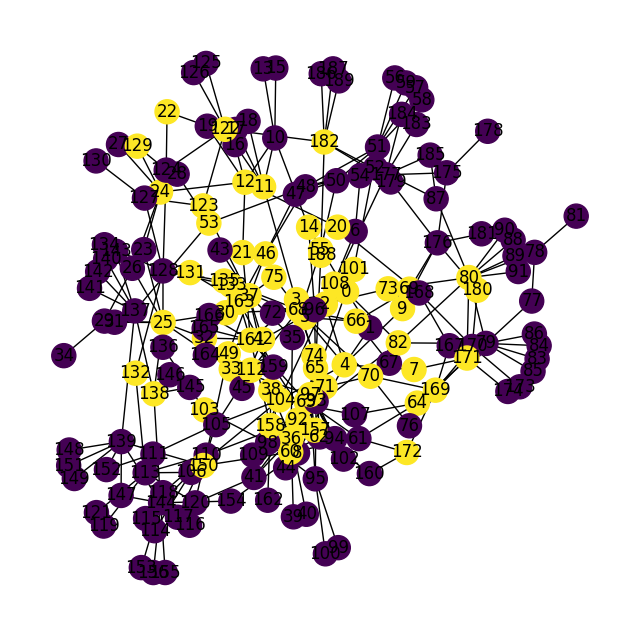

Data(x=[190, 10], edge_index=[2, 532], y=[190], shape=[190], train_mask=[190], valid_mask=[190], test_mask=[190], edge_weight=[532])


In [9]:

# Carrega o dataset e visualiza o grafo completo
dataset = ShapeGGen(
    model_layers=2,
    num_subgraphs=15,
    subgraph_size=13,
    prob_connection=0.3,
    add_sensitive_feature=False
)

plt.figure(figsize=(8, 8))
dataset.visualize(show=True)

# Obtém o grafo gerado
data = dataset.get_graph(use_fixed_split=True)

# Se edge_weight não existir ou for None, cria pesos unitários
if not hasattr(data, 'edge_weight') or data.edge_weight is None:
    data.edge_weight = torch.ones(data.edge_index.shape[1])
print(data)


In [10]:

print(f"Número total de nós: {data.x.shape[0]}")
print(f"Número total de arestas: {data.edge_index.shape[1]}")
print(f"Número de features por nó: {data.num_features}")
num_classes = int(data.y.max().item()) + 1
print(f"Número de classes: {num_classes}")

Número total de nós: 190
Número total de arestas: 532
Número de features por nó: 10
Número de classes: 2


In [11]:

# Funções auxiliares de treinamento e teste
def train_model(model, optimizer, criterion, data, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Se o método forward aceita edge_weight, passamos-o (ou None se não existir)
        if 'edge_weight' in model.forward.__code__.co_varnames:
            out = model(data.x, data.edge_index, getattr(data, 'edge_weight', None))
        else:
            out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return loss.item()

In [12]:
def test_model(model, data):
    model.eval()
    with torch.no_grad():
        if 'edge_weight' in model.forward.__code__.co_varnames:
            out = model(data.x, data.edge_index, getattr(data, 'edge_weight', None))
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc

In [13]:
# %% Seleção do modelo a ser explicado
# Altere esta variável para 'GCN', 'GCLSTM', 'GCRN' ou 'DCRN'
selected_model = 'GCN'

# Dicionário com mapeamento: nome -> (classe do modelo, nome da camada intermediária para o explainer)
models_dict = {
    'GCN': (GCN_2layer, 'conv2'),
    'GCLSTM': (GCLSTM, 'recurrent'),
    'GCRN': (GCRN, 'recurrent'),
    'DCRN': (DCRN, 'recurrent')
}

ModelClass, emb_layer_name = models_dict[selected_model]

# Instanciação do modelo com os parâmetros apropriados
if selected_model == 'GCN':
    # Para GCN_2layer, a assinatura é: (hidden_channels, in_channels, out_channels)
    # Portanto, defina 16 canais ocultos e in_channels igual a data.num_features
    model = ModelClass(16, data.num_features, num_classes)
else:
    model = ModelClass(in_channels=data.x.shape[1],
                       out_channels=16,
                       out=1,
                       num_classes=num_classes,
                       task_type='classification')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# %% Treinamento e avaliação
print(f"Treinando o modelo {selected_model}...")
train_loss = train_model(model, optimizer, criterion, data, epochs=200)
acc = test_model(model, data)
print(f"Desempenho do Modelo ({selected_model}): Loss final={train_loss:.4f}, ACC={acc:.4f}")

# %% Seleciona um nó para explicação
node_idx, gt_exp = dataset.choose_node(split='test')
print(f"Nó escolhido: {node_idx}")
print("Ground Truth Explanation:", gt_exp)


Treinando o modelo GCN...
Epoch 0, Loss: 0.7427
Epoch 50, Loss: 0.3455
Epoch 100, Loss: 0.2755
Epoch 150, Loss: 0.2013
Desempenho do Modelo (GCN): Loss final=0.1456, ACC=0.9362
Nó escolhido: 100
Ground Truth Explanation: [<graphxai.utils.explanation.Explanation object at 0x7edb6d584e10>]


In [14]:

# %% Treinamento dos Explicadores
# PGExplainer
pgex = PGExplainer(
    model,
    emb_layer_name=emb_layer_name,  # Usa a camada definida conforme o modelo selecionado
    max_epochs=10,
    lr=0.1,
)
pgex.train_explanation_model(data)

# Integrated Gradients
igex = IntegratedGradExplainer(
    model,
    criterion=criterion
)

133it [00:00, 231.07it/s]
133it [00:01, 121.76it/s]
133it [00:00, 195.50it/s]
133it [00:00, 195.19it/s]
133it [00:00, 156.12it/s]
133it [00:00, 150.12it/s]
133it [00:00, 165.01it/s]
133it [00:00, 193.74it/s]
133it [00:00, 196.65it/s]
133it [00:00, 200.33it/s]
133it [00:00, 196.69it/s]

training time is 7.8525s


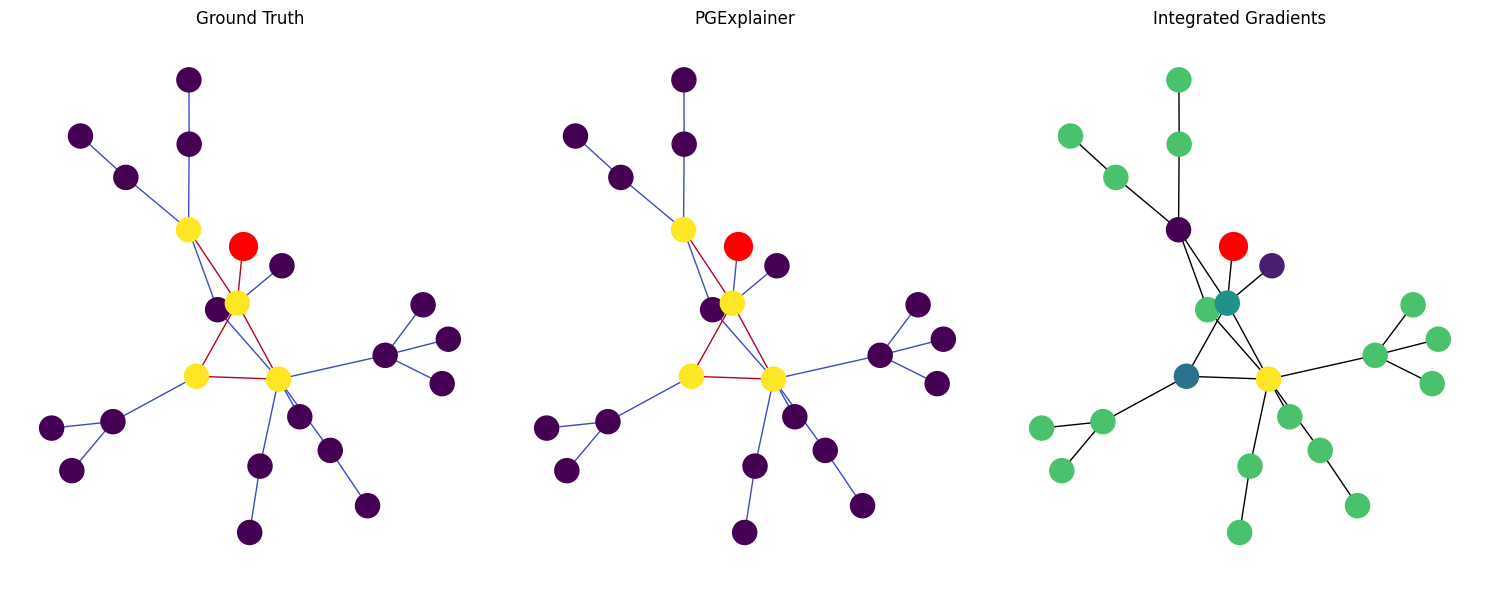

In [15]:
# %% Código para obter as explicações para o nó escolhido

# Verifica se o modelo selecionado é 'GCN' ou outro (por exemplo, modelo temporal)
if selected_model == 'GCN':
    # Para o GCN, a chamada é direta
    # Move data para o mesmo dispositivo do modelo
    device = next(model.parameters()).device  # Obtém o dispositivo do modelo
    data = data.to(device)
    pg_exp = pgex.get_explanation_node(node_idx=node_idx, x=data.x, edge_index=data.edge_index)
    ig_exp = igex.get_explanation_node(node_idx=node_idx, x=data.x, edge_index=data.edge_index, y=data.y)
else:
    # Para os modelos temporais, caso o forward exija edge_weight, passamos-o
    edge_weight = getattr(data, 'edge_weight', None)
    # Move data para o mesmo dispositivo do modelo
    device = next(model.parameters()).device  # Obtém o dispositivo do modelo
    data = data.to(device)
    pg_exp = pgex.get_explanation_node(node_idx=node_idx, x=data.x, edge_index=data.edge_index, edge_weight=edge_weight)
    ig_exp = igex.get_explanation_node(node_idx=node_idx, x=data.x, edge_index=data.edge_index, y=data.y, edge_weight=edge_weight)

# Move os dados de volta para a CPU antes da visualização
data = data.to('cpu')

# Mover os componentes internos do subgrafo para a CPU
pg_exp.enc_subgraph.edge_index = pg_exp.enc_subgraph.edge_index.to('cpu')
pg_exp.enc_subgraph.nodes = pg_exp.enc_subgraph.nodes.to('cpu')  # Características dos nós

ig_exp.enc_subgraph.edge_index = ig_exp.enc_subgraph.edge_index.to('cpu')
ig_exp.enc_subgraph.nodes = ig_exp.enc_subgraph.nodes.to('cpu')  # Características dos nós

gt_exp[0].enc_subgraph.edge_index = gt_exp[0].enc_subgraph.edge_index.to('cpu')
gt_exp[0].enc_subgraph.nodes = gt_exp[0].enc_subgraph.nodes.to('cpu')  # Características dos nós

# %% Visualização das explicações
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Visualiza a Ground Truth (usando o primeiro item se houver mais de um)
gt_exp[0].visualize_node(num_hops=3, graph_data=data, ax=ax[0])
ax[0].set_title("Ground Truth")

# Visualiza a explicação do PGExplainer
pg_exp.visualize_node(num_hops=3, graph_data=data, ax=ax[1])
ax[1].set_title("PGExplainer")

# Visualiza a explicação do Integrated Gradients
ig_exp.visualize_node(num_hops=3, graph_data=data, ax=ax[2])
ax[2].set_title("Integrated Gradients")

plt.tight_layout()
plt.show()
